# Importing

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install tensorflow

In [3]:
# Import libraries

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.impute import SimpleImputer

In [4]:
#  get a list of yml files
dir_path = os.path.join("/content/drive/My Drive/", "UBS_Challenge")
df_dir_path = os.path.join("/content/drive/My Drive/", "UBS_Challenge", "df_save")

In [5]:
# Load the DataFrame from the pickle file
loaded_df = pd.read_pickle(os.path.join(df_dir_path, "dummyTrade1_Expiry_3y_Tenor_3y.pkl"))

# Display the loaded DataFrame
loaded_df

,index,Date,Expiry,Tenor,Swap Rate,atm-1.0%,atm-0.5%,atm,atm+0.5%,atm+1.0%,...,Vega shock -25,Vega shock -10,Vega shock -5,Vega shock 0,Vega shock 5,Vega shock 10,Vega shock 25,Vega shock 50,Vega shock 75,Vega shock 100
0,0,2021-01-13,3y,3y,0.926464,0.126845,0.097976,0.064286,0.101715,0.138284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2021-01-15,3y,3y,0.909138,0.126421,0.098006,0.063943,0.101482,0.138040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2021-01-18,3y,3y,0.911595,0.126314,0.097693,0.063760,0.101355,0.137900,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2021-01-19,3y,3y,0.897848,0.125957,0.095190,0.063558,0.101041,0.137519,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2021-01-20,3y,3y,0.906676,0.126691,0.092632,0.064357,0.101635,0.138296,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,749,2024-01-08,3y,3y,3.110386,1.062981,1.065748,1.078728,1.101962,1.134488,...,13.054805,7.837098,11.382627,-10.217085,3.250830,-1.691202,-10.995377,2.988663,-1.774008,3.453038
750,750,2024-01-09,3y,3y,3.118041,1.053326,1.056185,1.069095,1.092077,1.124198,...,14.845626,12.220682,8.190720,3.654435,0.465170,-8.901062,1.681433,5.394763,0.341371,2.448011
751,751,2024-01-10,3y,3y,3.124089,1.078360,1.082165,1.095708,1.118975,1.151090,...,17.525630,0.038723,5.626285,-1.941919,1.514918,-6.057274,5.861185,5.004043,5.190675,4.022827
752,752,2024-01-11,3y,3y,3.080200,1.087504,1.092564,1.106701,1.129842,1.161218,...,8.916819,22.398760,21.049154,10.951858,4.202208,2.800921,-0.382249,-8.216384,7.142869,8.110645


# Data Pre-processing

In [6]:
n_clusters = 3 # Select n_clusters here

# Load the DataFrame from the pickle file
loaded_df = pd.read_pickle(os.path.join(df_dir_path, "dummyTrade1_Expiry_3y_Tenor_3y.pkl"))

loaded_df = loaded_df[['Date', 'Swap Rate', 'atm', 'Vega shock 0']]

# Rename the 'Vega shock 0' column
loaded_df.rename(columns={'atm': 'Implied Normal Volatility', 'Vega shock 0': 'Vega'}, inplace=True)

# Identify the first non-NaN index and count non-NaN values
first_non_nan_index = loaded_df['Vega'].first_valid_index()
non_nan_count = loaded_df['Vega'].count()

# Print the first non-NaN index and associated date
first_non_nan_date = loaded_df.loc[first_non_nan_index, 'Date']
print(f"First non-NaN index: {first_non_nan_index}, Date: {first_non_nan_date}")
print(f"Number of non-NaN values: {non_nan_count}")

# Identify the last NaN value's index
last_nan_index = loaded_df['Vega'][loaded_df['Vega'].isna()].index[-1]

# Print the last NaN index and associated date
last_nan_date = loaded_df.loc[last_nan_index, 'Date']
print(f"Last NaN index: {last_nan_index}, Date: {last_nan_date}")
print(f"First non-NaN index: {first_non_nan_index}")
print(f"Number of non-NaN values: {non_nan_count}")

print("\n\n=============\n\n")

# Function to compute moving averages and perform clustering
def compute_moving_average_and_clustering(df, column, window, shift_value, prefix):
    # Custom rolling mean function to handle partial windows
    df[f'{prefix}'] = df[column].rolling(window=window, min_periods=1).mean().shift(shift_value)

    # Extract non-NaN moving averages
    non_nan_moving_averages = df[f'{prefix}'].dropna().values.reshape(-1, 1)

    # Perform clustering with 4 clusters
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    cluster_labels = kmeans.fit_predict(non_nan_moving_averages)

    # Analyze the distribution of each cluster
    df[f'{prefix} Cluster'] = np.nan
    df.loc[df[f'{prefix}'].notna(), f'{prefix} Cluster'] = cluster_labels + 1

    # Calculate the medians of each cluster
    cluster_medians = df.loc[df[f'{prefix} Cluster'].notna(), [f'{prefix}', f'{prefix} Cluster']].groupby(f'{prefix} Cluster').median().abs()

    # Sort clusters by the absolute value of the median
    sorted_clusters = cluster_medians[f'{prefix}'].sort_values().index.tolist()

    # Remap cluster labels based on sorted order
    cluster_mapping = {old: new for new, old in enumerate(sorted_clusters, start=1)}
    df[f'{prefix} Cluster'] = df[f'{prefix} Cluster'].map(cluster_mapping)

    df[f'{prefix} Cluster'] = df[f'{prefix} Cluster'].astype('Int64')  # Convert to integer with NaN support

    for i in range(1, n_clusters + 1):
        cluster_data = df[df[f'{prefix} Cluster'] == i][f'{prefix}']
        print(f"Cluster {i} for {prefix}:")
        print(f"Min: {cluster_data.min()}")
        print(f"25th Percentile: {cluster_data.quantile(0.25)}")
        print(f"Median: {cluster_data.median()}")
        print(f"75th Percentile: {cluster_data.quantile(0.75)}")
        print(f"Max: {cluster_data.max()}")
        print("\n")

    # Categorize moving averages into clusters and create one-hot encoded columns
    def one_hot_encode_cluster(x, cluster_num):
        if pd.isna(x):
            return np.nan
        return 1 if x == cluster_num else 0

    # for i in range(1, n_clusters + 1):
    #     df[f'{prefix} Cluster {i}'] = df[f'{prefix} Cluster'].apply(lambda x: one_hot_encode_cluster(x, i)).astype('Int64')

    # # Ensure that cluster columns are NaN if the moving average is NaN
    # for i in range(1, n_clusters + 1):
    #     df[f'{prefix} Cluster {i}'] = df.apply(lambda row: np.nan if pd.isna(row[f'{prefix}']) else row[f'{prefix} Cluster {i}'], axis=1).astype('Int64')

# Define the windows
windows = {
    't+1 to t+5': (-1, -5)
}

# Apply the function to each window
for label, (start, end) in windows.items():
    compute_moving_average_and_clustering(loaded_df, 'Vega', start - end + 1, end, f'Vega MA {label}')

# Ensure that all columns are displayed
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Display the resulting DataFrame
loaded_df.tail(400)

First non-NaN index: 410, Date: 2022-09-02
Number of non-NaN values: 336
Last NaN index: 495, Date: 2023-01-02
First non-NaN index: 410
Number of non-NaN values: 336




Cluster 1 for Vega MA t+1 to t+5:
Min: -11.563781062
25th Percentile: 0.1880825399999986
Median: 2.83159744
75th Percentile: 8.816687646
Max: 16.554838044


Cluster 2 for Vega MA t+1 to t+5:
Min: 16.698747802
25th Percentile: 22.341648188
Median: 26.757079111
75th Percentile: 36.315728887
Max: 47.491319074


Cluster 3 for Vega MA t+1 to t+5:
Min: -11505.349523308
25th Percentile: -11502.908120558
Median: -11502.877896294
75th Percentile: -11502.149707084
Max: -11500.288522768




,Date,Swap Rate,Implied Normal Volatility,Vega,Vega MA t+1 to t+5,Vega MA t+1 to t+5 Cluster
354,2022-06-14,2.945934,0.072497,NaN,NaN,<NA>
355,2022-06-15,2.859921,0.072817,NaN,NaN,<NA>
356,2022-06-16,2.719031,0.070476,NaN,NaN,<NA>
357,2022-06-17,2.682615,0.069588,NaN,NaN,<NA>
358,2022-06-20,2.619587,0.067884,NaN,NaN,<NA>
359,2022-06-21,2.765887,0.068706,NaN,NaN,<NA>
360,2022-06-22,2.654932,0.067491,NaN,NaN,<NA>
361,2022-06-23,2.555744,0.067024,NaN,NaN,<NA>
362,2022-06-24,2.626183,0.068052,NaN,NaN,<NA>
363,2022-06-27,2.684751,0.067528,NaN,NaN,<NA>


# LSTM - Classification

In [17]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 60

# Hyperparameters
epochs=250
batch_size=32

# ################ Start of Impute ########################

# # Impute NaN values with the mean of the column
# imputer = SimpleImputer(strategy='mean')
# df[['Swap Rate', 'Implied Normal Volatility', 'Vega']] = imputer.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# # Standardize the features
# scaler = StandardScaler()
# features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# # Function to create sequences
# def create_sequences(features, target, n_steps):
#     X, y = [], []
#     for i in range(n_steps, len(features)):
#         X.append(features[i-n_steps:i, :])
#         y.append(target[i])
#     return np.array(X), np.array(y)

# # Create sequences for the entire dataset
# X, y = create_sequences(features, df['Vega MA t+1 to t+5 Cluster'].values.astype(float), n_steps)

# # Filter out sequences where the target value is NaN
# valid_indices = ~pd.isna(y)
# X = X[valid_indices]
# y = y[valid_indices].astype(int)  # Ensure y is integer type

# # Adjust y to be 0, 1, 2 for the model training
# y_adjusted = y - 1

# # Convert targets to categorical
# y_categorical = pd.get_dummies(y_adjusted).values

# ################ End of Impute ########################

################ Start of Exclusion ########################

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5 Cluster'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN or any feature value is NaN
valid_indices = ~np.isnan(y) & ~np.isnan(X).any(axis=(0, 1, 2))
X = X[valid_indices]
y = y[valid_indices].astype(int)  # Ensure y is integer type

# Adjust y to be 0, 1, 2 for the model training
y_adjusted = y - 1

# Convert targets to categorical
y_categorical = pd.get_dummies(y_adjusted).values


################ End of Exclusion ########################


# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y_categorical[:-60], y_categorical[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define checkpoint to save the best model
checkpoint_filepath = os.path.join(dir_path, 'best_lstm_classification_model.h5')
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_accuracy', mode='max')

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Save the final model weights
model.save_weights(os.path.join(dir_path, 'lstm_classification_final_weights.h5'))

# Print the training and testing loss and accuracy
training_loss = history.history['loss']
testing_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
testing_accuracy = history.history['val_accuracy']

print("Training Loss:", training_loss)
print("Testing Loss:", testing_loss)
print("Training Accuracy:", training_accuracy)
print("Testing Accuracy:", testing_accuracy)

Epoch 1/250
9/9 [==============================] - 7s 189ms/step - loss: 1.0143 - accuracy: 0.6585 - val_loss: 1.5335 - val_accuracy: 0.0500
Epoch 2/250
1/9 [==>...........................] - ETA: 0s - loss: 0.8546 - accuracy: 0.9375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 1s 106ms/step - loss: 0.8113 - accuracy: 0.8908 - val_loss: 2.2344 - val_accuracy: 0.0500
Epoch 3/250
9/9 [==============================] - 1s 70ms/step - loss: 0.5802 - accuracy: 0.8838 - val_loss: 2.1796 - val_accuracy: 0.0500
Epoch 4/250
9/9 [==============================] - 1s 65ms/step - loss: 0.4386 - accuracy: 0.8873 - val_loss: 1.6616 - val_accuracy: 0.0500
Epoch 5/250
9/9 [==============================] - 1s 75ms/step - loss: 0.3883 - accuracy: 0.8944 - val_loss: 1.9751 - val_accuracy: 0.0500
Epoch 6/250
9/9 [==============================] - 1s 71ms/step - loss: 0.3422 - accuracy: 0.9049 - val_loss: 1.9983 - val_accuracy: 0.0500
Epoch 7/250
9/9 [==============================] - 1s 69ms/step - loss: 0.3374 - accuracy: 0.9049 - val_loss: 1.9485 - val_accuracy: 0.0500
Epoch 8/250
9/9 [==============================] - 1s 72ms/step - loss: 0.3064 - accuracy: 0.9049 - val_loss: 1.6590 - val_accuracy: 0.0500
Epoch 9/250
9/9 [==============

In [8]:
training_loss = [1.074563980102539, 0.8843479752540588, 0.6708327531814575, 0.5378776788711548, 0.4007204473018646, 0.38620027899742126, 0.4451953172683716, 0.3525746166706085, 0.33439701795578003, 0.3487987816333771, 0.4322994351387024, 0.3151791989803314, 0.3080267608165741, 0.27090299129486084, 0.2900904715061188, 0.2792584300041199, 0.2591916620731354, 0.25289711356163025, 0.25176578760147095, 0.28379809856414795, 0.2578493654727936, 0.23602834343910217, 0.2509475350379944, 0.22946330904960632, 0.24052850902080536, 0.25787487626075745, 0.24334093928337097, 0.23464590311050415, 0.2296280860900879, 0.2354496717453003, 0.22870010137557983, 0.23006345331668854, 0.22180522978305817, 0.23762448132038116, 0.20515811443328857, 0.20210577547550201, 0.21678325533866882, 0.2108331024646759, 0.20074892044067383, 0.22270838916301727, 0.4566965103149414, 0.49184250831604004, 0.5094966888427734, 0.39256298542022705, 0.3504098057746887, 0.32538509368896484, 0.283324271440506, 0.29534029960632324, 0.2745513916015625, 0.2383423149585724, 0.210648313164711, 0.22243423759937286, 0.2198575735092163, 0.2042042315006256, 0.20750850439071655, 0.2135164886713028, 0.2153545618057251, 0.21915990114212036, 0.2433198243379593, 0.22891288995742798, 0.24454471468925476, 0.22708886861801147, 0.21953445672988892, 0.22437846660614014, 0.22237230837345123, 0.23363293707370758, 0.23494172096252441, 0.2051950842142105, 0.22522291541099548, 0.20559106767177582, 0.21229790151119232, 0.207430899143219, 0.19970867037773132, 0.20477397739887238, 0.18911457061767578, 0.19377483427524567, 0.19363118708133698, 0.20240743458271027, 0.2069435864686966, 0.2252126932144165, 0.22368726134300232, 0.2033408135175705, 0.1864178478717804, 0.1858113557100296, 0.18793632090091705, 0.17712567746639252, 0.17526429891586304, 0.1919875144958496, 0.18494334816932678, 0.17978975176811218, 0.1914440393447876, 0.18100371956825256, 0.17864762246608734, 0.18114909529685974, 0.17176540195941925, 0.18983128666877747, 0.1890718936920166, 0.1935608983039856, 0.18952138721942902, 0.18289175629615784, 0.18510545790195465, 0.16956782341003418, 0.17605780065059662, 0.17755253612995148, 0.18655003607273102, 0.1749987006187439, 0.1668461263179779, 0.16461777687072754, 0.17863139510154724, 0.20829389989376068, 0.18690747022628784, 0.16304153203964233, 0.1827683448791504, 0.1861647516489029, 0.181157186627388, 0.17006610333919525, 0.1722690463066101, 0.16297486424446106, 0.1751972883939743, 0.17681823670864105, 0.17751234769821167, 0.17897489666938782, 0.16778872907161713, 0.1588737666606903, 0.16485248506069183, 0.1741250604391098, 0.16440142691135406, 0.15781597793102264, 0.1623895764350891, 0.15931254625320435, 0.1644158512353897, 0.1622685194015503, 0.16837210953235626, 0.1569940149784088, 0.1644674688577652, 0.20100590586662292, 0.19598489999771118, 0.17645050585269928, 0.16824638843536377, 0.15540660917758942, 0.15871423482894897, 0.16181986033916473, 0.1618489921092987, 0.16335168480873108, 0.16219408810138702, 0.1531212478876114, 0.1486271470785141, 0.14514297246932983, 0.14927938580513, 0.144102081656456, 0.16622142493724823, 0.14476922154426575, 0.140590101480484, 0.14092254638671875, 0.1317341923713684, 0.1291484236717224, 0.15578676760196686, 0.14164914190769196, 0.15818406641483307, 0.14018574357032776, 0.1411915421485901, 0.12593203783035278, 0.1246454045176506, 0.14951996505260468, 0.13461092114448547, 0.13827696442604065, 0.12613223493099213, 0.11241703480482101, 0.11052947491407394, 0.12145751714706421, 0.12645599246025085, 0.11781476438045502, 0.11937658488750458, 0.12391473352909088, 0.10950189083814621, 0.12923653423786163, 0.12565308809280396, 0.12880948185920715, 0.1370968073606491, 0.12116910517215729, 0.13309688866138458, 0.10745992511510849, 0.11073854565620422, 0.11817926913499832, 0.11540751159191132, 0.10735207051038742, 0.10502894222736359, 0.12323300540447235, 0.12943601608276367, 0.11105962842702866, 0.1196647584438324, 0.1057177186012268, 0.10075538605451584, 0.09285930544137955, 0.10450489819049835, 0.11396075040102005, 0.1090012788772583, 0.11007514595985413, 0.08893055468797684, 0.10968706756830215, 0.11297672986984253, 0.12233006209135056, 0.12727148830890656, 0.11309881508350372, 0.14313390851020813, 0.11676977574825287, 0.10073184967041016, 0.09728716313838959, 0.11288248002529144, 0.0982651636004448, 0.10339125245809555, 0.0966658815741539, 0.10276074707508087, 0.1108463779091835, 0.1005142331123352, 0.10493292659521103, 0.13247665762901306, 0.1114017516374588, 0.14433105289936066, 0.22407948970794678, 0.17803272604942322, 0.17438440024852753, 0.16066008806228638, 0.15967294573783875, 0.15767847001552582, 0.16035538911819458, 0.1555582582950592, 0.14454872906208038, 0.14546801149845123, 0.14977309107780457, 0.15077084302902222, 0.1376270204782486, 0.12933126091957092, 0.11844085901975632, 0.12366551160812378, 0.10966458171606064, 0.1181604340672493, 0.10935858637094498, 0.0947151929140091, 0.10595516115427017, 0.12596261501312256, 0.09756527841091156, 0.1265898495912552, 0.1072215735912323, 0.10089006274938583, 0.09247013181447983, 0.08087767660617828, 0.09312203526496887, 0.0955142229795456, 0.09689296036958694]
testing_loss = [1.0813558101654053, 1.1100181341171265, 3.7910919189453125, 1.6236422061920166, 2.1489858627319336, 1.1028239727020264, 1.6535403728485107, 1.4150704145431519, 1.4395487308502197, 1.5680019855499268, 1.7640831470489502, 1.931681513786316, 1.9598586559295654, 2.094266176223755, 1.8733859062194824, 1.7261217832565308, 1.9472320079803467, 1.8717892169952393, 1.6685678958892822, 1.7172486782073975, 1.590523600578308, 1.7165052890777588, 1.6931684017181396, 1.4921447038650513, 1.6091954708099365, 1.522274136543274, 1.1203384399414062, 1.5840222835540771, 1.366574764251709, 1.7743868827819824, 1.6458683013916016, 1.3547672033309937, 1.533869981765747, 1.329876184463501, 1.4803529977798462, 1.5015099048614502, 1.3705575466156006, 1.447063684463501, 1.7563832998275757, 1.2255338430404663, 1.181505560874939, 0.6354032754898071, 0.7180345058441162, 0.7293661236763, 1.6558161973953247, 1.721940517425537, 1.016389012336731, 1.4768048524856567, 1.6547229290008545, 1.5428985357284546, 1.7522128820419312, 1.9979661703109741, 1.6411114931106567, 1.3047451972961426, 1.4500579833984375, 1.8100321292877197, 1.8716717958450317, 2.003366231918335, 1.1377815008163452, 0.8507205843925476, 1.128638505935669, 1.3279637098312378, 1.4168665409088135, 1.4691600799560547, 1.6194884777069092, 1.5834215879440308, 1.5156317949295044, 1.3491538763046265, 1.2755439281463623, 1.3265135288238525, 1.3601149320602417, 1.12921142578125, 1.314133882522583, 1.387099027633667, 1.3325344324111938, 1.5528939962387085, 1.783105731010437, 1.9510915279388428, 1.499427318572998, 1.2608389854431152, 1.1255028247833252, 1.5446126461029053, 1.6828080415725708, 1.846532940864563, 1.8136719465255737, 1.88190495967865, 2.1253366470336914, 2.3412678241729736, 1.986580491065979, 2.1300787925720215, 2.1879007816314697, 1.7684555053710938, 2.013596534729004, 2.2220468521118164, 2.4317986965179443, 2.078707456588745, 0.9840821027755737, 0.8213585019111633, 1.5404725074768066, 1.6658869981765747, 1.7906062602996826, 1.798931360244751, 2.119880199432373, 2.1653192043304443, 2.607032299041748, 2.4690349102020264, 2.521352529525757, 2.248323917388916, 2.1345345973968506, 2.2826015949249268, 1.2981504201889038, 1.5065420866012573, 1.7991530895233154, 1.1655910015106201, 1.8395334482192993, 0.8402740359306335, 2.201685905456543, 2.3966293334960938, 2.465263605117798, 1.7456837892532349, 1.0731947422027588, 1.5435165166854858, 0.7788264751434326, 0.6194493770599365, 1.1547003984451294, 0.8472512364387512, 3.35139799118042, 3.2820794582366943, 3.0303397178649902, 3.4912290573120117, 3.161471128463745, 3.2054784297943115, 3.3072595596313477, 3.346494197845459, 1.740938663482666, 2.1958441734313965, 1.7306666374206543, 1.935363531112671, 2.923849582672119, 3.2193450927734375, 3.1569433212280273, 3.278787136077881, 2.607417583465576, 1.012271523475647, 2.1526381969451904, 2.04626202583313, 2.6212968826293945, 3.419724941253662, 5.5566086769104, 7.138503074645996, 6.212780952453613, 6.662569522857666, 6.817439556121826, 8.768152236938477, 6.968240737915039, 9.369952201843262, 8.009998321533203, 9.331307411193848, 8.095288276672363, 3.5667355060577393, 6.03322172164917, 3.4565212726593018, 6.088698387145996, 4.467405796051025, 2.5337395668029785, 3.845245838165283, 3.873478412628174, 3.187020778656006, 4.8400421142578125, 4.009048938751221, 4.690503120422363, 5.434693336486816, 5.358078956604004, 5.428715705871582, 6.4346160888671875, 6.365813255310059, 7.337771415710449, 5.653913497924805, 7.975786209106445, 4.338479518890381, 4.537179470062256, 3.7944154739379883, 3.44181227684021, 3.8845021724700928, 5.182096004486084, 5.835599899291992, 4.209188938140869, 3.6033530235290527, 3.6222424507141113, 3.674194097518921, 4.648019313812256, 5.141509532928467, 4.7428436279296875, 5.290394306182861, 4.079127311706543, 3.133906364440918, 5.411912441253662, 4.474272727966309, 4.356108665466309, 3.717477321624756, 4.145151615142822, 3.8900418281555176, 4.141829967498779, 5.703223705291748, 2.766268491744995, 2.6575028896331787, 2.486717700958252, 3.531686544418335, 2.901911973953247, 2.8399598598480225, 2.6214118003845215, 2.172175884246826, 2.540186643600464, 2.5088980197906494, 2.9500017166137695, 3.841912031173706, 4.18021821975708, 3.821075677871704, 4.964337348937988, 3.674485683441162, 3.4869914054870605, 1.2946889400482178, 0.7813836932182312, 1.4702357053756714, 2.140949249267578, 2.3844823837280273, 2.133039712905884, 1.9727729558944702, 0.7117202877998352, 0.7459962368011475, 0.6112033128738403, 0.8453014492988586, 1.0455278158187866, 0.990224301815033, 1.4276787042617798, 1.0770419836044312, 1.459615707397461, 2.35241961479187, 3.2970519065856934, 3.408879280090332, 1.9484621286392212, 2.0616350173950195, 2.343940258026123, 2.461686134338379, 2.8166465759277344, 2.5042176246643066, 3.497544288635254, 3.0551061630249023, 2.360079526901245, 1.77228581905365]
training_accuracy = [0.5316901206970215, 0.8485915660858154, 0.8767605423927307, 0.8802816867828369, 0.8767605423927307, 0.9014084339141846, 0.8838028311729431, 0.908450722694397, 0.9119718074798584, 0.9154929518699646, 0.8978873491287231, 0.9119718074798584, 0.9049295783042908, 0.9190140962600708, 0.9154929518699646, 0.9154929518699646, 0.922535240650177, 0.9190140962600708, 0.9154929518699646, 0.9119718074798584, 0.922535240650177, 0.922535240650177, 0.9190140962600708, 0.9260563254356384, 0.9190140962600708, 0.9154929518699646, 0.9119718074798584, 0.922535240650177, 0.9119718074798584, 0.9154929518699646, 0.9190140962600708, 0.9190140962600708, 0.922535240650177, 0.9190140962600708, 0.9260563254356384, 0.922535240650177, 0.9154929518699646, 0.922535240650177, 0.922535240650177, 0.922535240650177, 0.908450722694397, 0.908450722694397, 0.8978873491287231, 0.8978873491287231, 0.8908450603485107, 0.9154929518699646, 0.9119718074798584, 0.9014084339141846, 0.908450722694397, 0.9190140962600708, 0.922535240650177, 0.922535240650177, 0.9260563254356384, 0.9260563254356384, 0.922535240650177, 0.908450722694397, 0.9260563254356384, 0.9190140962600708, 0.9014084339141846, 0.922535240650177, 0.9119718074798584, 0.922535240650177, 0.9154929518699646, 0.9190140962600708, 0.9190140962600708, 0.9154929518699646, 0.9154929518699646, 0.9260563254356384, 0.9190140962600708, 0.9260563254356384, 0.922535240650177, 0.9154929518699646, 0.9260563254356384, 0.9260563254356384, 0.9260563254356384, 0.9260563254356384, 0.9049295783042908, 0.9260563254356384, 0.922535240650177, 0.9154929518699646, 0.9154929518699646, 0.9119718074798584, 0.9190140962600708, 0.9154929518699646, 0.9295774698257446, 0.9260563254356384, 0.9295774698257446, 0.9154929518699646, 0.9260563254356384, 0.922535240650177, 0.922535240650177, 0.922535240650177, 0.9190140962600708, 0.922535240650177, 0.9260563254356384, 0.9154929518699646, 0.9190140962600708, 0.9190140962600708, 0.9190140962600708, 0.9190140962600708, 0.9154929518699646, 0.9260563254356384, 0.9190140962600708, 0.922535240650177, 0.9154929518699646, 0.9260563254356384, 0.922535240650177, 0.9190140962600708, 0.9190140962600708, 0.9014084339141846, 0.9260563254356384, 0.922535240650177, 0.9154929518699646, 0.9295774698257446, 0.9190140962600708, 0.9260563254356384, 0.9330986142158508, 0.922535240650177, 0.9295774698257446, 0.922535240650177, 0.9190140962600708, 0.9190140962600708, 0.9154929518699646, 0.9295774698257446, 0.9190140962600708, 0.9260563254356384, 0.9295774698257446, 0.9295774698257446, 0.922535240650177, 0.9295774698257446, 0.9366196990013123, 0.9366196990013123, 0.9295774698257446, 0.9295774698257446, 0.9330986142158508, 0.908450722694397, 0.9260563254356384, 0.9190140962600708, 0.9260563254356384, 0.9295774698257446, 0.9330986142158508, 0.9401408433914185, 0.9366196990013123, 0.9295774698257446, 0.922535240650177, 0.9436619877815247, 0.9436619877815247, 0.9330986142158508, 0.9471830725669861, 0.9366196990013123, 0.9295774698257446, 0.9401408433914185, 0.9542253613471985, 0.9366196990013123, 0.9436619877815247, 0.9507042169570923, 0.9154929518699646, 0.9436619877815247, 0.9119718074798584, 0.9436619877815247, 0.9295774698257446, 0.9436619877815247, 0.9401408433914185, 0.9330986142158508, 0.9330986142158508, 0.9366196990013123, 0.9436619877815247, 0.9507042169570923, 0.9542253613471985, 0.9295774698257446, 0.9471830725669861, 0.9401408433914185, 0.9401408433914185, 0.9507042169570923, 0.9436619877815247, 0.9401408433914185, 0.9436619877815247, 0.9295774698257446, 0.9295774698257446, 0.9401408433914185, 0.9507042169570923, 0.9471830725669861, 0.9612675905227661, 0.9436619877815247, 0.9471830725669861, 0.9507042169570923, 0.9507042169570923, 0.9366196990013123, 0.9436619877815247, 0.9612675905227661, 0.9471830725669861, 0.9507042169570923, 0.9401408433914185, 0.9577465057373047, 0.9471830725669861, 0.9507042169570923, 0.9507042169570923, 0.9366196990013123, 0.9577465057373047, 0.9577465057373047, 0.9612675905227661, 0.9471830725669861, 0.9471830725669861, 0.9542253613471985, 0.9436619877815247, 0.9507042169570923, 0.9507042169570923, 0.9577465057373047, 0.9471830725669861, 0.9542253613471985, 0.9507042169570923, 0.9577465057373047, 0.9436619877815247, 0.9436619877815247, 0.9542253613471985, 0.9471830725669861, 0.9401408433914185, 0.9507042169570923, 0.9330986142158508, 0.908450722694397, 0.9049295783042908, 0.9260563254356384, 0.9190140962600708, 0.9190140962600708, 0.9190140962600708, 0.9190140962600708, 0.922535240650177, 0.9295774698257446, 0.9295774698257446, 0.9260563254356384, 0.9260563254356384, 0.9330986142158508, 0.9507042169570923, 0.9542253613471985, 0.9471830725669861, 0.9612675905227661, 0.9471830725669861, 0.9507042169570923, 0.9577465057373047, 0.9507042169570923, 0.9507042169570923, 0.9507042169570923, 0.9647887349128723, 0.9436619877815247, 0.9577465057373047, 0.9577465057373047, 0.9542253613471985, 0.9542253613471985, 0.9612675905227661, 0.9471830725669861]
testing_accuracy = [0.20000000298023224, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.7666666507720947, 0.7333333492279053, 0.7833333611488342, 0.0833333358168602, 0.0833333358168602, 0.5, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.13333334028720856, 0.6333333253860474, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.5, 0.0833333358168602, 0.0833333358168602, 0.4833333194255829, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.5, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.23333333432674408, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.7833333611488342, 0.75, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.3499999940395355, 0.0833333358168602, 0.5666666626930237, 0.4000000059604645, 0.30000001192092896, 0.7833333611488342, 0.23333333432674408, 0.8833333253860474, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.30000001192092896, 0.6666666865348816, 0.5166666507720947, 0.7833333611488342, 0.699999988079071, 0.5333333611488342, 0.699999988079071, 0.6666666865348816, 0.6333333253860474, 0.6666666865348816, 0.0833333358168602, 0.0833333358168602, 0.0833333358168602, 0.3499999940395355, 0.3166666626930237, 0.6666666865348816, 0.3333333432674408, 0.699999988079071, 0.46666666865348816, 0.3166666626930237, 0.4166666567325592, 0.4166666567325592, 0.38333332538604736, 0.44999998807907104, 0.7333333492279053, 0.6833333373069763, 0.699999988079071, 0.6666666865348816, 0.6666666865348816, 0.6166666746139526, 0.6000000238418579, 0.6166666746139526, 0.6333333253860474, 0.6333333253860474, 0.5833333134651184, 0.6166666746139526, 0.6166666746139526, 0.6166666746139526, 0.5833333134651184, 0.6333333253860474, 0.36666667461395264, 0.6666666865348816, 0.699999988079071, 0.6666666865348816, 0.4000000059604645, 0.5666666626930237, 0.5333333611488342, 0.6666666865348816, 0.5333333611488342, 0.6499999761581421, 0.4333333373069763, 0.4833333194255829, 0.6499999761581421, 0.6666666865348816, 0.3499999940395355, 0.6666666865348816, 0.6333333253860474, 0.6333333253860474, 0.30000001192092896, 0.30000001192092896, 0.6833333373069763, 0.6666666865348816, 0.6833333373069763, 0.6833333373069763, 0.6833333373069763, 0.6333333253860474, 0.6333333253860474, 0.38333332538604736, 0.20000000298023224, 0.6666666865348816, 0.4333333373069763, 0.6333333253860474, 0.6166666746139526, 0.6499999761581421, 0.6666666865348816, 0.4333333373069763, 0.3499999940395355, 0.6333333253860474, 0.6499999761581421, 0.6666666865348816, 0.5666666626930237, 0.3333333432674408, 0.699999988079071, 0.6833333373069763, 0.6666666865348816, 0.36666667461395264, 0.3333333432674408, 0.4000000059604645, 0.30000001192092896, 0.3333333432674408, 0.6499999761581421, 0.6499999761581421, 0.6666666865348816, 0.6499999761581421, 0.6499999761581421, 0.6499999761581421, 0.6499999761581421, 0.6166666746139526, 0.25, 0.28333333134651184, 0.23333333432674408, 0.0833333358168602, 0.20000000298023224, 0.550000011920929, 0.15000000596046448, 0.0833333358168602, 0.3499999940395355, 0.3499999940395355, 0.36666667461395264, 0.7833333611488342, 0.75, 0.7833333611488342, 0.8333333134651184, 0.9166666865348816, 0.9166666865348816, 0.800000011920929, 0.75, 0.6000000238418579, 0.3166666626930237, 0.1666666716337204, 0.23333333432674408, 0.699999988079071, 0.7666666507720947, 0.23333333432674408, 0.3499999940395355, 0.18333333730697632, 0.699999988079071, 0.6833333373069763, 0.699999988079071, 0.6000000238418579, 0.75]

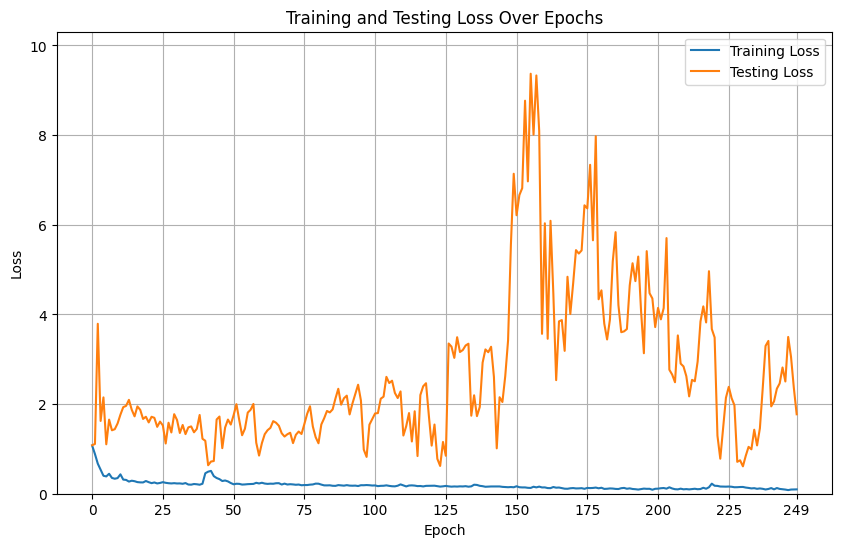

In [9]:
# Plot the training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(testing_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()

# Customize x-ticks to show epoch for every appropriate interval and the last epoch
epoch_ticks = list(range(0, len(training_loss), max(1, len(training_loss) // 10))) + [len(training_loss) - 1]
plt.xticks(epoch_ticks)

plt.ylim(0, max(max(training_loss), max(testing_loss)) * 1.1)  # Add some padding to y-axis
plt.grid(True)
plt.show()

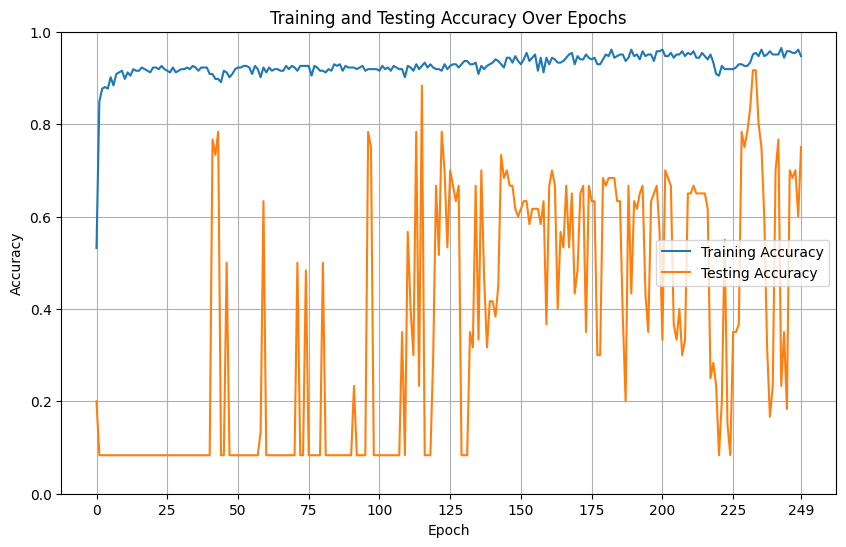

In [10]:
# Plot the training and testing accuracy
plt.figure(figsize=(10, 6))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(testing_accuracy, label='Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy Over Epochs')
plt.legend()

# Customize x-ticks to show epoch for every appropriate interval and the last epoch
epoch_ticks = list(range(0, len(training_accuracy), max(1, len(training_accuracy) // 10))) + [len(training_accuracy) - 1]
plt.xticks(epoch_ticks)

plt.ylim(0, 1)  # Accuracy is typically between 0 and 1
plt.grid(True)
plt.show()

2/2 [==============================] - 1s 30ms/step


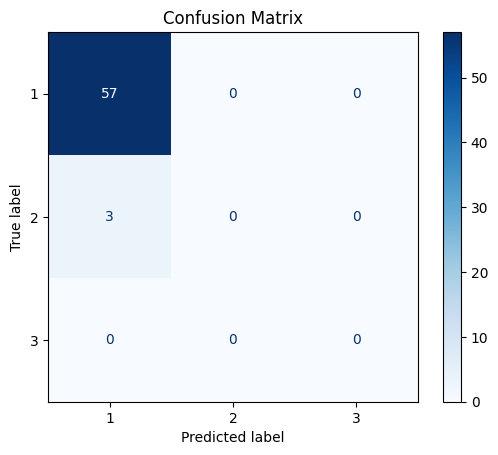

In [18]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 60

# Hyperparameters
epochs=100
batch_size=32

# ################ Start of Impute ########################

# # Impute NaN values with the mean of the column
# imputer = SimpleImputer(strategy='mean')
# df[['Swap Rate', 'Implied Normal Volatility', 'Vega']] = imputer.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# # Standardize the features
# scaler = StandardScaler()
# features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# # Function to create sequences
# def create_sequences(features, target, n_steps):
#     X, y = [], []
#     for i in range(n_steps, len(features)):
#         X.append(features[i-n_steps:i, :])
#         y.append(target[i])
#     return np.array(X), np.array(y)

# # Create sequences for the entire dataset
# X, y = create_sequences(features, df['Vega MA t+1 to t+5 Cluster'].values.astype(float), n_steps)

# # Filter out sequences where the target value is NaN
# valid_indices = ~pd.isna(y)
# X = X[valid_indices]
# y = y[valid_indices].astype(int)  # Ensure y is integer type

# # Adjust y to be 0, 1, 2 for the model training
# y_adjusted = y - 1

# # Convert targets to categorical
# y_categorical = pd.get_dummies(y_adjusted).values

# ################ End of Impute ########################

################ Start of Exclusion ########################

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5 Cluster'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN or any feature value is NaN
valid_indices = ~np.isnan(y) & ~np.isnan(X).any(axis=(0, 1, 2))
X = X[valid_indices]
y = y[valid_indices].astype(int)  # Ensure y is integer type

# Adjust y to be 0, 1, 2 for the model training
y_adjusted = y - 1

# Convert targets to categorical
y_categorical = pd.get_dummies(y_adjusted).values


################ End of Exclusion ########################

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y_categorical[:-60], y_categorical[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Load the model weights
model.load_weights(os.path.join(dir_path, 'best_lstm_classification_model.h5'))

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Adjust the classes back to 1, 2, 3
y_pred_classes_adjusted = y_pred_classes + 1
y_test_classes_adjusted = y_test_classes + 1

# Compute and display the confusion matrix
cm = confusion_matrix(y_test_classes_adjusted, y_pred_classes_adjusted, labels=[1, 2, 3])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[1, 2, 3])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# LSTM - Prediction

In [19]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 60

# Hyperparameters
epochs = 250
batch_size = 32

# # ################ Start of Impute ########################

# # Impute NaN values with the mean of the column
# imputer = SimpleImputer(strategy='mean')
# df[['Swap Rate', 'Implied Normal Volatility', 'Vega']] = imputer.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# # Standardize the features
# scaler = StandardScaler()
# features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# # Function to create sequences
# def create_sequences(features, target, n_steps):
#     X, y = [], []
#     for i in range(n_steps, len(features)):
#         X.append(features[i-n_steps:i, :])
#         y.append(target[i])
#     return np.array(X), np.array(y)

# # Create sequences for the entire dataset
# X, y = create_sequences(features, df['Vega MA t+1 to t+5'].values.astype(float), n_steps)

# # Filter out sequences where the target value is NaN
# valid_indices = ~pd.isna(y)
# X = X[valid_indices]
# y = y[valid_indices]  # Keep y as float for regression

# # ################ End of Impute ########################

################ Start of Exclusion ########################

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN or any feature value is NaN
valid_indices = ~np.isnan(y) & ~np.isnan(X).any(axis=(0, 1, 2))
X = X[valid_indices]
y = y[valid_indices]  # Keep y as float for regression

################ End of Exclusion ########################

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y[:-60], y[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for regression

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Define checkpoint to save the best model based on validation loss
checkpoint_filepath = os.path.join(dir_path, 'best_lstm_prediction_model.h5')
checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[checkpoint])

# Save the final model weights
model.save_weights(os.path.join(dir_path, 'lstm_prediction_final_weights.h5'))

# Print the training and testing loss and accuracy
training_loss = history.history['loss']
testing_loss = history.history['val_loss']
training_mse = history.history['mean_squared_error']
testing_mse = history.history['val_mean_squared_error']

print("Training Loss:", training_loss)
print("Testing Loss:", testing_loss)
print("Training MSE:", training_mse)
print("Testing MSE:", testing_mse)

Epoch 1/250
9/9 [==============================] - 4s 129ms/step - loss: 2329815.7500 - mean_squared_error: 2329815.7500 - val_loss: 98.2019 - val_mean_squared_error: 98.2019
Epoch 2/250
2/9 [=====>........................] - ETA: 0s - loss: 2068681.1250 - mean_squared_error: 2068681.1250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


9/9 [==============================] - 1s 76ms/step - loss: 2329752.2500 - mean_squared_error: 2329752.2500 - val_loss: 93.0142 - val_mean_squared_error: 93.0142
Epoch 3/250
9/9 [==============================] - 1s 105ms/step - loss: 2329952.7500 - mean_squared_error: 2329952.7500 - val_loss: 44.1699 - val_mean_squared_error: 44.1699
Epoch 4/250
9/9 [==============================] - 1s 103ms/step - loss: 2328844.2500 - mean_squared_error: 2328844.2500 - val_loss: 88.3203 - val_mean_squared_error: 88.3203
Epoch 5/250
9/9 [==============================] - 1s 100ms/step - loss: 2582634.7500 - mean_squared_error: 2582634.7500 - val_loss: 91.7037 - val_mean_squared_error: 91.7037
Epoch 6/250
9/9 [==============================] - 1s 106ms/step - loss: 2328811.7500 - mean_squared_error: 2328811.7500 - val_loss: 92.4035 - val_mean_squared_error: 92.4035
Epoch 7/250
9/9 [==============================] - 1s 100ms/step - loss: 2329221.7500 - mean_squared_error: 2329221.7500 - val_loss: 92.69

In [13]:
training_loss = [2329838.75, 2329777.25, 2329709.75, 2329511.0, 2330930.0, 53436387328.0, 2329592.75, 2329576.0, 2329571.5, 2329562.5, 2329634.0, 2329608.5, 2329556.25, 2329573.25, 2329534.75, 2329552.25, 2329544.75, 2329558.75, 2329539.75, 2329495.5, 2329492.25, 2329477.25, 2329588.0, 2329456.75, 2329461.75, 2329396.25, 2329384.0, 2329338.25, 2329149.75, 2328801.5, 3589073.5, 2329533.5, 2329633.0, 2329655.25, 2329712.0, 2329694.75, 2329706.5, 2329698.75, 2329712.75, 2329694.0, 2329691.5, 2329712.25, 2329700.0, 2329678.75, 2329708.75, 2329695.75, 2329703.25, 2329686.5, 2329692.25, 2329680.5, 2329692.25, 2329697.25, 2329683.5, 2329685.75, 2329682.5, 2329690.25, 2329682.5, 2329694.75, 2329696.0, 2329683.5, 2329697.25, 2329686.75, 2329687.0, 2329695.5, 2329685.25, 2329685.25, 2329702.25, 2329678.75, 2329688.25, 2329677.0, 2329678.5, 2329685.25, 2329670.75, 2329689.75, 2329676.5, 2329675.0, 2329671.0, 2329681.5, 2329687.5, 2329712.25, 2329695.75, 2329676.5, 2329697.25, 2329688.75, 2329687.25, 2329688.25, 2329667.5, 2329666.25, 2329675.0, 2329682.25, 2329685.75, 2329675.75, 2329690.25, 2329674.25, 2329677.25, 2329673.25, 2329666.25, 2329678.75, 2329671.5, 2329672.25, 2329664.75, 2329673.75, 2329678.25, 2329670.5, 2329664.5, 2329666.0, 2329665.0, 2329671.0, 2329664.0, 2329653.75, 2329662.75, 2329667.5, 2329665.25, 2329658.0, 2329670.0, 2329656.25, 2329646.0, 2329643.75, 2329650.75, 2329629.25, 2329665.5, 2329638.0, 2329629.0, 2329647.0, 2329619.0, 2329603.5, 2329601.0, 2329591.5, 2329556.0, 2329484.0, 2329461.75, 2329378.5, 2333527.5, 2329396.25, 2329494.75, 2329522.25, 2329535.25, 2329521.5, 2329538.75, 2329513.0, 2329524.25, 2329532.5, 2329521.5, 2329510.25, 2329533.75, 2329493.75, 2329527.5, 2329506.0, 2329501.0, 2329474.5, 2329537.5, 2329491.5, 2329522.0, 2329486.75, 2329498.25, 2329462.25, 2329447.0, 2329444.5, 2329461.75, 2329428.0, 2329464.0, 2329459.75, 2329402.25, 2329460.5, 2329447.0, 2329452.25, 2329438.25, 2329347.75, 2329412.5, 2329374.75, 2329395.25, 2329361.5, 2329415.75, 2329349.75, 2329399.5, 2329355.25, 2329318.75, 2329365.75, 2329307.25, 2329390.75, 2329286.75, 2329231.0, 2329293.0, 2329304.75, 2329258.75, 2329129.5, 2329116.0, 2329108.75, 2329029.75, 2328952.25, 2328955.5, 2329029.75, 2328757.75, 2327132.5, 2323573.25, 2459448.25, 2329828.5, 2329617.25, 2329628.25, 2329608.5, 2329635.5, 2329637.25, 2329607.25, 2329639.25, 2329618.25, 2329643.0, 2329653.0, 2329611.25, 2329625.75, 2329633.75, 2329612.0, 2329621.75, 2329621.25, 2329623.0, 2329638.25, 2329610.25, 2329601.0, 2329603.5, 2329608.25, 2329609.75, 2329605.75, 2329631.0, 2329596.5, 2329623.25, 2329601.25, 2329600.5, 2329608.0, 2329621.5, 2329594.0, 2329596.5, 2329649.25, 2329639.5, 2329617.5, 2329623.5, 2329637.75, 2329645.5, 2329633.75, 2329619.0, 2329607.5, 2329636.0, 2329620.75, 2329614.0, 2329607.5, 2329625.75, 2329602.0, 2329608.75, 2329604.25, 2329608.0, 2329601.5, 2329603.0]
testing_loss = [93.14937591552734, 188.73512268066406, 179.01234436035156, 90.06369018554688, 90.12227630615234, 91.78074645996094, 93.86331176757812, 94.56033325195312, 94.85311126708984, 94.99036407470703, 95.08448791503906, 95.14454650878906, 95.18070220947266, 95.14043426513672, 94.98120880126953, 94.67544555664062, 94.10542297363281, 93.41077423095703, 93.31983947753906, 92.85108947753906, 92.18191528320312, 91.3370132446289, 91.98171997070312, 93.3582534790039, 93.7903823852539, 93.99526977539062, 94.10948944091797, 94.22595977783203, 94.36073303222656, 94.3468017578125, 92.82086944580078, 90.82250213623047, 89.98263549804688, 89.61022186279297, 89.47594451904297, 89.42586517333984, 89.42569732666016, 89.43794250488281, 89.45079040527344, 89.46994018554688, 89.49835968017578, 89.5186996459961, 89.53445434570312, 89.54225158691406, 89.550537109375, 89.56012725830078, 89.57340240478516, 89.58626556396484, 89.59387969970703, 89.59758758544922, 89.61418914794922, 89.62158203125, 89.63191986083984, 89.62122344970703, 89.62091827392578, 89.63706970214844, 89.63987731933594, 89.64871215820312, 89.66724395751953, 89.67648315429688, 89.68983459472656, 89.69611358642578, 89.71022033691406, 89.72034454345703, 89.72457122802734, 89.7337875366211, 89.7348861694336, 89.73429870605469, 89.72542572021484, 89.68603515625, 89.627197265625, 89.53858947753906, 89.39775085449219, 89.1654052734375, 88.8292007446289, 88.54328155517578, 88.3749008178711, 88.010986328125, 87.28888702392578, 89.38748168945312, 90.02165985107422, 90.21866607666016, 90.2818832397461, 90.30838012695312, 90.30184173583984, 90.28473663330078, 90.28251647949219, 90.27391052246094, 90.25829315185547, 90.24661254882812, 90.23109436035156, 90.20783233642578, 90.18907928466797, 90.16504669189453, 90.15205383300781, 90.12617492675781, 90.08293151855469, 90.04660034179688, 90.0176773071289, 89.98970794677734, 89.95592498779297, 89.9103012084961, 89.8623046875, 89.79585266113281, 89.73049926757812, 89.66252899169922, 89.5826644897461, 89.51339721679688, 89.43313598632812, 89.34049224853516, 89.23219299316406, 89.09407043457031, 88.9522933959961, 88.7479476928711, 88.51213836669922, 88.17569732666016, 87.6533203125, 87.34612274169922, 87.20194244384766, 87.27204895019531, 88.07852172851562, 88.32503509521484, 88.28016662597656, 88.06855773925781, 87.76966857910156, 87.76213836669922, 87.6133804321289, 87.5017318725586, 87.76549530029297, 87.6154556274414, 87.41860961914062, 87.52234649658203, 88.62498474121094, 89.2077865600586, 89.36129760742188, 89.34516143798828, 89.24443054199219, 89.10340118408203, 88.91768646240234, 88.69001007080078, 88.52644348144531, 88.3357925415039, 88.46233367919922, 88.45976257324219, 88.23029327392578, 88.2470474243164, 88.4854507446289, 88.47914123535156, 88.54569244384766, 88.8073959350586, 88.83157348632812, 88.745849609375, 88.69835662841797, 88.63589477539062, 88.5119400024414, 88.28224182128906, 87.96189880371094, 87.77851867675781, 87.650390625, 88.22888946533203, 88.50109100341797, 88.45729064941406, 88.32071685791016, 88.285400390625, 88.20523071289062, 88.00820922851562, 88.09530639648438, 88.21560668945312, 88.23757934570312, 88.20751953125, 88.09404754638672, 87.76882934570312, 87.4920883178711, 88.25547790527344, 88.62299346923828, 88.59904479980469, 88.48001098632812, 88.26367950439453, 88.06289672851562, 87.78648376464844, 87.79743194580078, 87.72506713867188, 87.93505859375, 87.96294403076172, 88.19083404541016, 88.36570739746094, 88.29723358154297, 88.0753173828125, 87.85160827636719, 87.5681381225586, 87.44688415527344, 87.32166290283203, 87.30180358886719, 87.31436920166016, 87.62307739257812, 86.14122772216797, 91.94075775146484, 92.91981506347656, 93.23067474365234, 93.34814453125, 93.39601135253906, 93.41927337646484, 93.433349609375, 93.44086456298828, 93.44822692871094, 93.45679473876953, 93.46510314941406, 93.47254180908203, 93.47321319580078, 93.48110961914062, 93.48917388916016, 93.49815368652344, 93.50830841064453, 93.51493072509766, 93.52360534667969, 93.53292846679688, 93.54065704345703, 93.54875183105469, 93.55525207519531, 93.56443786621094, 93.57383728027344, 93.5859146118164, 93.59414672851562, 93.60014343261719, 93.60746765136719, 93.61445617675781, 93.62361907958984, 93.63768005371094, 93.64595031738281, 93.66028594970703, 93.66751861572266, 93.67135620117188, 93.67628479003906, 93.68556213378906, 93.69246673583984, 93.70075988769531, 93.708740234375, 93.71725463867188, 93.726318359375, 93.74244689941406, 93.75048065185547, 93.75426483154297, 93.7643814086914, 93.77244567871094, 93.78317260742188, 93.79806518554688, 93.80597686767578, 93.81442260742188, 93.82060241699219, 93.82589721679688]

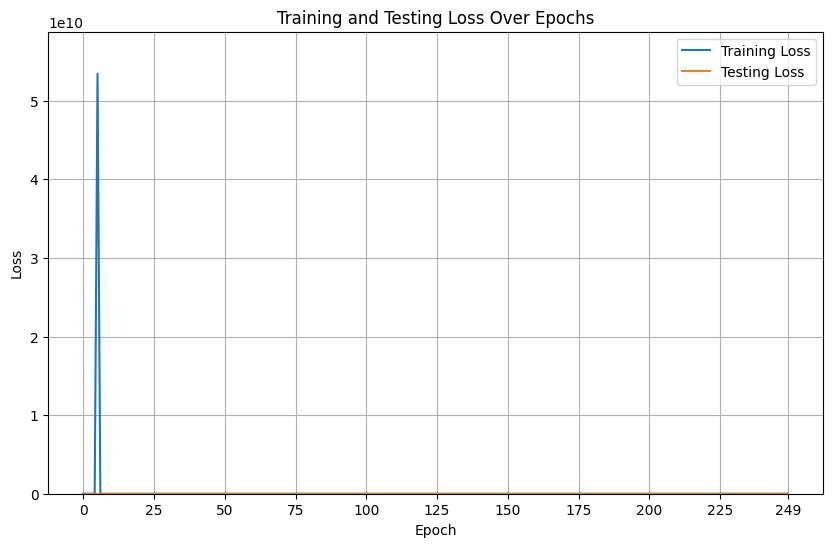

In [14]:
# Plot the training and testing loss
plt.figure(figsize=(10, 6))
plt.plot(training_loss, label='Training Loss')
plt.plot(testing_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()

# Customize x-ticks to show epoch for every appropriate interval and the last epoch
epoch_ticks = list(range(0, len(training_loss), max(1, len(training_loss) // 10))) + [len(training_loss) - 1]
plt.xticks(epoch_ticks)

plt.ylim(0, max(max(training_loss), max(testing_loss)) * 1.1)  # Add some padding to y-axis
plt.grid(True)
plt.show()

2/2 [==============================] - 0s 34ms/step
y_pred: [[ 4.0967484]
 [ 4.0181155]
 [ 3.9660304]
 [ 3.9386218]
 [ 3.9292943]
 [ 3.9407623]
 [ 3.9706864]
 [ 4.0147476]
 [ 4.0730114]
 [ 4.1385317]
 [ 4.219331 ]
 [ 4.318184 ]
 [ 4.4315267]
 [ 4.55107  ]
 [ 4.6689787]
 [ 4.785669 ]
 [ 4.910696 ]
 [ 5.030799 ]
 [ 5.152853 ]
 [ 5.2887564]
 [ 5.4428844]
 [ 5.609694 ]
 [ 5.783366 ]
 [ 5.9861913]
 [ 6.212282 ]
 [ 6.4647946]
 [ 6.7464957]
 [ 7.0624905]
 [ 7.4197946]
 [ 7.814761 ]
 [ 8.248407 ]
 [ 8.710458 ]
 [ 9.174848 ]
 [ 9.666458 ]
 [10.202067 ]
 [10.763727 ]
 [11.346963 ]
 [11.949415 ]
 [12.555512 ]
 [13.129041 ]
 [13.663486 ]
 [14.130548 ]
 [14.567367 ]
 [14.943307 ]
 [15.227707 ]
 [15.445055 ]
 [15.651325 ]
 [15.814004 ]
 [15.933041 ]
 [16.007502 ]
 [16.071182 ]
 [16.122763 ]
 [16.127266 ]
 [16.13062  ]
 [16.124426 ]
 [16.198072 ]
 [16.374422 ]
 [16.552813 ]
 [16.673382 ]
 [16.694136 ]]
Mean Squared Error: 44.1699
Mean Absolute Error: 5.4098


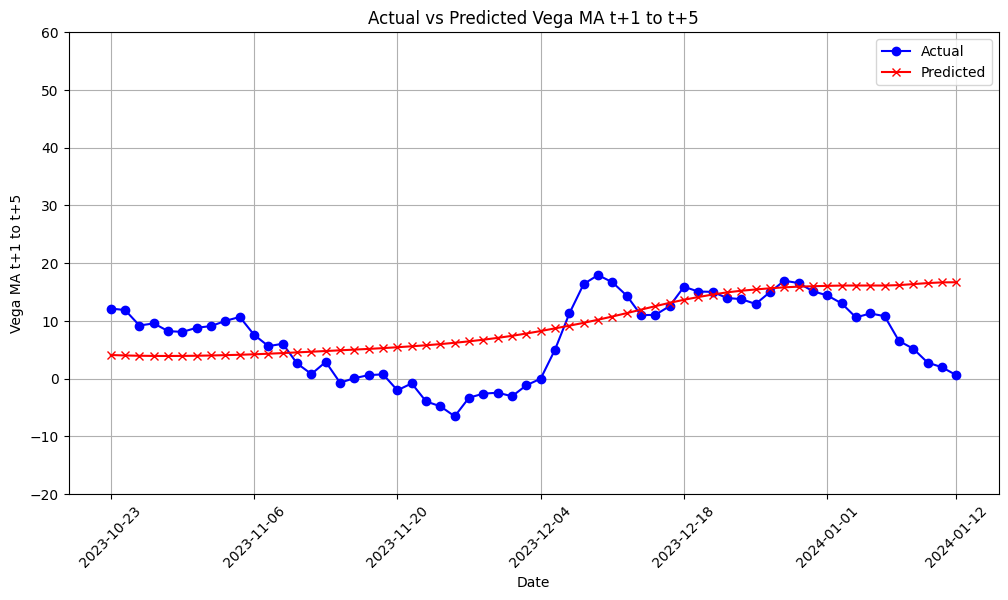

In [20]:
# Prepare the data
df = loaded_df
n_features = 3  # 'Swap Rate', 'Implied Normal Volatility', 'Vega'
n_steps = 60

# # ################ Start of Impute ########################

# # Impute NaN values with the mean of the column
# imputer = SimpleImputer(strategy='mean')
# df[['Swap Rate', 'Implied Normal Volatility', 'Vega']] = imputer.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# # Standardize the features
# scaler = StandardScaler()
# features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# # Function to create sequences
# def create_sequences(features, target, n_steps):
#     X, y = [], []
#     for i in range(n_steps, len(features)):
#         X.append(features[i-n_steps:i, :])
#         y.append(target[i])
#     return np.array(X), np.array(y)

# # Create sequences for the entire dataset
# X, y = create_sequences(features, df['Vega MA t+1 to t+5'].values.astype(float), n_steps)

# # Filter out sequences where the target value is NaN
# valid_indices = ~pd.isna(y)
# X = X[valid_indices]
# y = y[valid_indices]  # Keep y as float for regression

# # ################ End of Impute ########################

################ Start of Exclusion ########################

# Standardize the features
scaler = StandardScaler()
features = scaler.fit_transform(df[['Swap Rate', 'Implied Normal Volatility', 'Vega']])

# Function to create sequences
def create_sequences(features, target, n_steps):
    X, y = [], []
    for i in range(n_steps, len(features)):
        X.append(features[i-n_steps:i, :])
        y.append(target[i])
    return np.array(X), np.array(y)

# Create sequences for the entire dataset
X, y = create_sequences(features, df['Vega MA t+1 to t+5'].values.astype(float), n_steps)

# Filter out sequences where the target value is NaN or any feature value is NaN
valid_indices = ~np.isnan(y) & ~np.isnan(X).any(axis=(0, 1, 2))
X = X[valid_indices]
y = y[valid_indices]  # Keep y as float for regression

################ End of Exclusion ########################

# Split the data into training and testing
X_train, X_test = X[:-60], X[-60:]
y_train, y_test = y[:-60], y[-60:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1))  # Single output for regression

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Load the model weights
model.load_weights(os.path.join(dir_path, 'best_lstm_prediction_model.h5'))

# Make predictions
y_pred = model.predict(X_test)

# Print y_pred
print(f"y_pred: {y_pred}")

# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

# Plot real vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(df['Date'][-len(y_test):], y_test, label='Actual', color='blue', marker='o')
plt.plot(df['Date'][-len(y_pred):], y_pred, label='Predicted', color='red', marker='x')

# Customize x-ticks to show date for every 10 entries and the last date
xticks = list(range(0, len(y_test), 10)) + [len(y_test) - 1]
xtick_labels = df['Date'].values[-len(y_test):][xticks]
plt.xticks(xticks, xtick_labels, rotation=45)

plt.xlabel('Date')
plt.ylabel('Vega MA t+1 to t+5')
plt.title('Actual vs Predicted Vega MA t+1 to t+5')
plt.legend()
plt.ylim(-20, 60)
# plt.axvline(x=xticks[-61], color='grey', linestyle='--')  # Vertical line at the last 60th date
plt.grid(True)
plt.show()